# **<font color='yellow'>Handling data quality issues in a time-series: Fuel LBP rates:</font>**

## *<font color='orange'>Data set:</font>*

The data set is a comma-separated values (CSV) file that contains the evolution of the fuel prices in Lebanon from 11-8-2021 till 5-9-2023 collected from the Lira Rate website.<br>We ignored the values before 11-08-2021, as this is the date of the removal of fuel subsidies by the Lebanese government.<br>


**• DateTime:** The timestamp<br>
**• OCTANE 95 (LBP)**<br>
**• OCTANE 98 (LBP)**<br>
**• DIESEL (LBP)**<br>
**• GAS (LBP)**<br>
**• BRENT CRUDE OIL (USD)**<br>
**• USD to LBP:** The market rate of the Lebanese Lira compared to 1 USD.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
data1=pd.read_csv('fuel-LBP-rates (2).csv')
data1.head(3)

,DateTime,OCTANE 95 (LBP),OCTANE 98 (LBP),DIESEL (LBP),GAS (LBP),BRENT CRUDE OIL (USD),USD to LBP
0,8/11/2021 09:19,NaN,NaN,NaN,NaN,NaN,20575.0
1,8/11/2021 11:32,NaN,NaN,NaN,NaN,NaN,20500.0
2,8/11/2021 13:55,NaN,NaN,NaN,NaN,NaN,20550.0


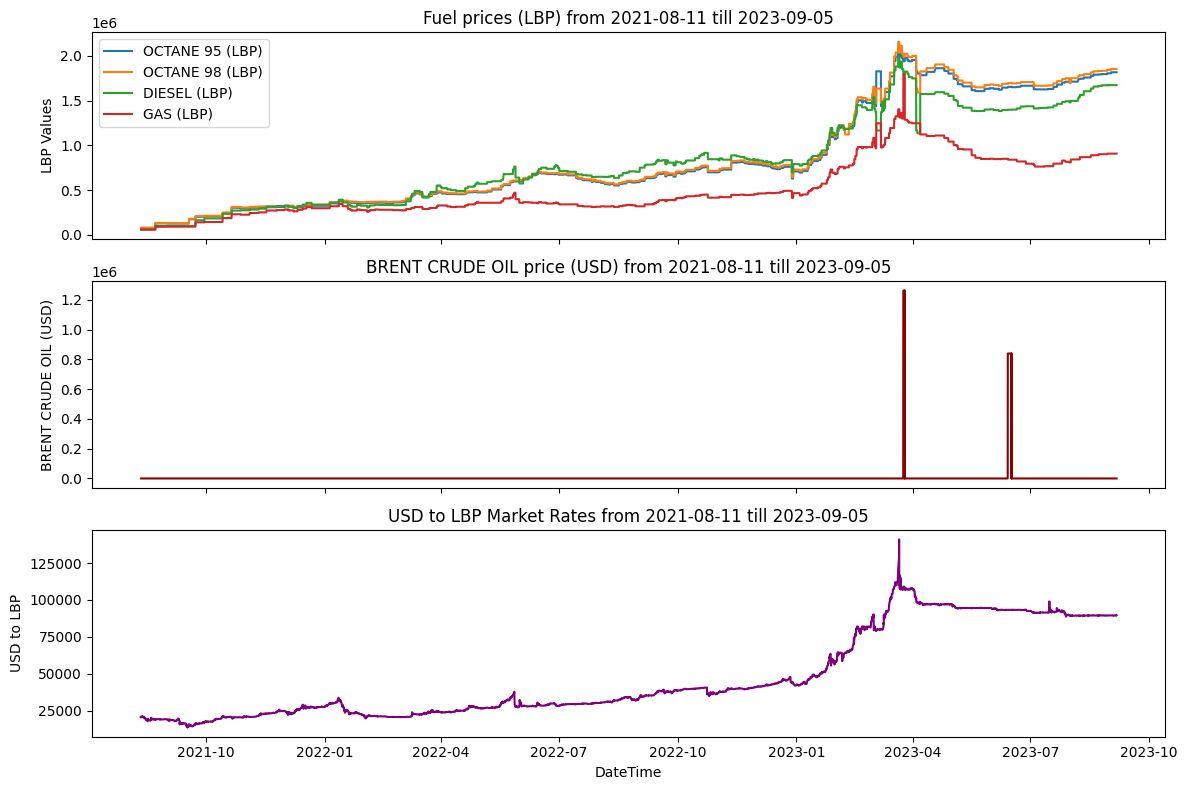

In [52]:
# Creating the figure for all subplots:
fig, axes= plt.subplots(nrows=3,ncols=1,figsize=(12,8),sharex=True)
# converting the datetime column into datetime format:
datetime1=pd.to_datetime(data1['DateTime'])
# Creating a loop to plot the lebanese fuel prices with the 2nd, 3rd,4th and 5th columns:
lbp_columns = data1.columns[1:5] 
for column in lbp_columns:
     axes[0].plot(datetime1, data1[column], label=column)
# Customizing the subplot:
axes[0].set_ylabel('LBP Values')
axes[0].set_title('Fuel prices (LBP) from 2021-08-11 till 2023-09-05')
axes[0].legend(loc='upper left')

#Plotting Brent crude oil price:
axes[1].plot(datetime1, data1['BRENT CRUDE OIL (USD)'], color='darkred', label='BRENT CRUDE OIL (USD)')
axes[1].set_ylabel('BRENT CRUDE OIL (USD)')
axes[1].set_title('BRENT CRUDE OIL price (USD) from 2021-08-11 till 2023-09-05')

#Plotting The USD to LPB rates:
axes[2].plot(datetime1, data1['USD to LBP'], color='purple', label='USD to LBP')
axes[2].set_xlabel('DateTime')
axes[2].set_ylabel('USD to LBP') 
axes[2].set_title('USD to LBP Market Rates from 2021-08-11 till 2023-09-05')

plt.tight_layout()
plt.show()

 Several issues exist in the visualized data:<br>
• The first two subplots are almost empty and do not show any data<br>
• The second subplot Y-Axis values are irrelevant

## *<font color='orange'>Handling Missing values:* </font>

In [44]:
# forward fill method:
data1.fillna(method='ffill',inplace=True)


C:\Users\Legion\AppData\Local\Temp\ipykernel_30608\3028642921.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data1.fillna(method='ffill',inplace=True)


After handling the missing values, the second subplot remains the main issue in our visualized data.<br>
All values are mostly zeros except two peaks.<br>
This situation requires more investigation to check whether these values are accurate or if some outliers and noisy data are causing this issue.

In [45]:
# we also have other methods to fill in missing values:
# df.fillna(method='bfill') # backward fill means taking the value of the next object
# df.fillna(value=0) #replacing the missing data with the values that i want.
# df.interpolate(method='linear') or quadratic.
"""
In linear interpolation, missing values are estimated
as a linear function of the neighboring data points.
The missing values are filled in a way that assumes a straight-line
relationship between the existing values.
"""
"""
In quadratic interpolation, missing values are estimated 
using a quadratic function fitted to the neighboring data points.
This method assumes a curved relationship between the existing values.
"""
# df.fillna(method='ffill',limit=2)
"""
limit=2:
This parameter limits the number of consecutive missing values
that will be forward-filled to a maximum of 2.
In other words, if there are more than 2 consecutive NaN values in a column,
only the first two will be filled, 
and subsequent NaN values after that will remain as NaN.
"""
# df.fillna(df.mean())
# df.fillna(df.median())

'\nlimit=2:\nThis parameter limits the number of consecutive missing values\nthat will be forward-filled to a maximum of 2.\nIn other words, if there are more than 2 consecutive NaN values in a column,\nonly the first two will be filled, \nand subsequent NaN values after that will remain as NaN.\n'

## *<font color='orange'>Outliers:</font>*

In [46]:
# Checking the outliers of the brent crude oil which is the second subplot
print('Minimum value: ' + str(data1['BRENT CRUDE OIL (USD)'].min()))
print('Maximum value: ' + str(data1['BRENT CRUDE OIL (USD)'].max()))
print('Mean value: ' + str(data1['BRENT CRUDE OIL (USD)'].mean()))
print('Median value: ' + str(data1['BRENT CRUDE OIL (USD)'].median()))

Minimum value: 68.75
Maximum value: 1263000.0
Mean value: 4232.46343587971
Median value: 85.72


From the printed values, we can conclude that our data contains some outliers affecting the 
data chart.<br>
The maximum value is erroneous as it is inconsistent that the Brent crude oil price is 1263000 USD.<br>
Also, the wide difference between the Mean and Median indicates that extreme values may exist.


### Computing the IQR range 

In [47]:
# Sorting the DataFrame by the 'BRENT CRUDE OIL (USD)' column in ascending order
#data1= data1.sort_values(by='BRENT CRUDE OIL (USD)', ascending=True)

In [48]:
Q1 = data1['BRENT CRUDE OIL (USD)'].quantile(0.25)
Q3 = data1['BRENT CRUDE OIL (USD)'].quantile(0.75)
IQR = (Q3-Q1)
#Then, we define a threshold for extreme outliers:
threshold = 1.5 * IQR
# we can replace the outliers with the average of their neighboring values:
outliers = (data1['BRENT CRUDE OIL (USD)'] < (Q1-threshold)) | (data1['BRENT CRUDE OIL (USD)'] > (Q3+threshold))
for i in range(1, len(data1) - 1):
    if outliers[i]:
        data1.loc[i-1, 'BRENT CRUDE OIL (USD)'] = (data1.loc[i+1, 'BRENT CRUDE OIL (USD)'] + data1.loc[i+1, 'BRENT CRUDE OIL (USD)']) / 2  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


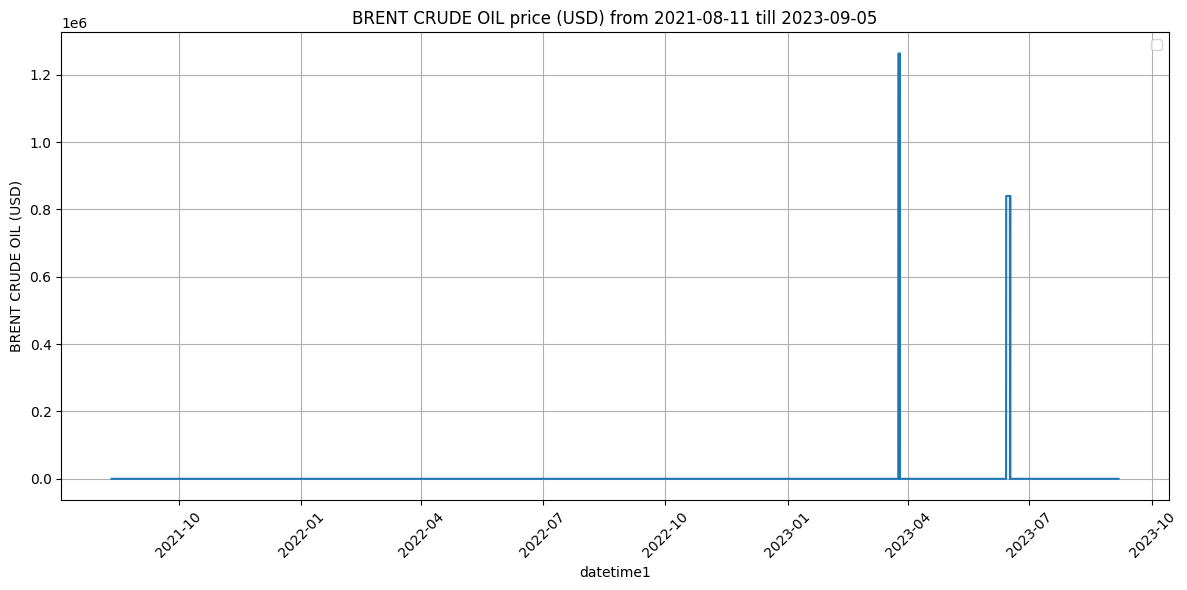

In [49]:
#Plotting Brent crude oil price:
datetime1=pd.to_datetime(data1['DateTime'])
plt.figure(figsize=(12,6))
plt.plot(datetime1,data1['BRENT CRUDE OIL (USD)'])
plt.xlabel('datetime1')
plt.ylabel('BRENT CRUDE OIL (USD)')
plt.title('BRENT CRUDE OIL price (USD) from 2021-08-11 till 2023-09-05')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Still, there is an issue in the first subplot, where 
the last values suddenly decrease to near-zero, which requires more investigation

## Handling numerical precision issues:<br>
The last appearing in our visualized data is the tail or the line charts plotted in the first subplot, where suddenly all values decrease to a very low value.<br>This strange behavior requires some investigation.<br>
To get more details, we need to use the DataFrame.tail() method to retrieve the last entries in our data.<br>Let's check the last 25 rows by adding the following line of code right after the fillna() method.

In [50]:
data1.tail(25)

,DateTime,OCTANE 95 (LBP),OCTANE 98 (LBP),DIESEL (LBP),GAS (LBP),BRENT CRUDE OIL (USD),USD to LBP
5766,8/31/2023 17:33,1805000.0,1843000.0,1673000.0,907000.0,85.33,89500.0
5767,8/31/2023 19:30,1805000.0,1843000.0,1673000.0,907000.0,85.33,89500.0
5768,8/31/2023 20:45,1805000.0,1843000.0,1673000.0,907000.0,85.33,89500.0
5769,9/1/2023 9:39,1805000.0,1843000.0,1673000.0,907000.0,85.33,89500.0
5770,9/1/2023 11:55,1805000.0,1843000.0,1673000.0,907000.0,85.33,89500.0
5771,9/1/2023 15:17,1817.0,1854.0,1673.0,908.0,87.70,89500.0
5772,9/1/2023 15:53,1817.0,1854.0,1673.0,908.0,87.70,89500.0
5773,9/2/2023 9:30,1817.0,1854.0,1673.0,908.0,87.70,89500.0
5774,9/2/2023 13:32,1817.0,1854.0,1673.0,908.0,87.70,89400.0
5775,9/2/2023 17:07,1817.0,1854.0,1673.0,908.0,87.70,89400.0


In [51]:
threshold=10000
#Identify rows with precision issues
precision_issues=data1[(data1['OCTANE 95 (LBP)']<threshold) & (data1['OCTANE 98 (LBP)']<threshold) & (data1['DIESEL (LBP)']<threshold) & (data1['GAS (LBP)']<threshold)]
# Multiply values in the affected columns by 1000 to correct precision
affected_columns=['OCTANE 95 (LBP)','OCTANE 98 (LBP)','DIESEL (LBP)','GAS (LBP)']
data1.loc[precision_issues.index, affected_columns]*=1000

We can conclude the correlation between the fuel 
prices and the Lebanese Lira market rate as the line trends look very similar.<br> The correlation with the 
crude oil price needs more statistical investigation and cannot be concluded from the visual perception